In [1]:
%matplotlib inline
import dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit, minimize_scalar
from IPython.display import clear_output
import allantools
import matplotlib as mpl

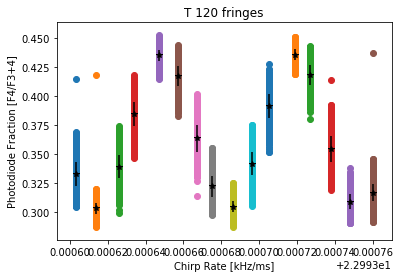

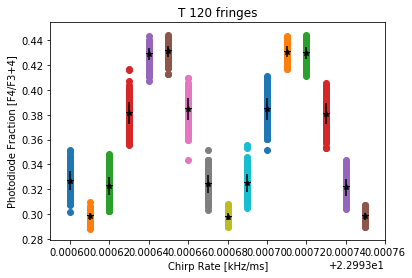

In [10]:
def pull_data_from_db(db, table_name):
    xs = []
    query1 = "SELECT DISTINCT chirp FROM %s" % (table_name)
    for row in db.query(query1):
        xs.append(float(row['chirp']))
    xs = sorted(xs)
    ys = []
    start_adding = False
    for row in db.load_table(table_name).all():
        chirp = float(row['chirp'])
        pd = float(row['pd'])
        if not start_adding and chirp != xs[0]:
            # Only start creating the dataset at the start of a fringe
            continue
        start_adding = True
        curr_chirp = chirp
        try:
            ys[xs.index(chirp)].append(pd)
        except IndexError:
            ys.append([pd])
            
    if curr_chirp != xs[-1]:
        # Drop the last point if we didn't get a full fringe on the last one
        for c in xs:
            if c<=curr_chirp:
                ys[xs.index(c)] = ys[xs.index(c)][:-1]
    
    num_fringes = len(ys[0])
    num_pts_per_fringe = len(xs)
    
    for xe, ye in zip(xs, ys):
        assert(num_fringes == len(ye))
        plt.errorbar(xe, np.average(ye), fmt='k*:', yerr = np.std(ye))
        plt.scatter([xe] * len(ye), ye)

    plt.xlim(min(xs) - 0.00001, max(xs) + 0.00001)
    plt.xlabel("Chirp Rate [kHz/ms]")
    plt.ylabel("Photodiode Fraction [F4/F3+4]")
    plt.title(table_name.replace('_', ' '))
    plt.show()

    return xs, ys, num_fringes, num_pts_per_fringe
        
def get_fringe_pd(i, xs, ys):
    pd = []
    for x in xs:
        pd.append(ys[xs.index(x)][i])
    return pd

xs_mcu, ys_mcu, num_fringes_mcu, num_pts_per_fringe_mcu = pull_data_from_db(dataset.connect('sqlite:///MCU_gravity_11272018_130MOT.db'), 'T_120_fringes')
xs_cicero, ys_cicero, num_fringes_cicero, num_pts_per_fringe_cicero = pull_data_from_db(dataset.connect('sqlite:///cicero_11_28.db'), 'T_120_fringes')

In [1]:
for xe, ye in zip(xs_mcu, ys_mcu):
    plt.errorbar(xe, np.average(ye), fmt='k*:', yerr = np.std(ye))
plt.xticks([22.9936, 22.99364,22.99368,22.99372,22.99376])
plt.xlabel("Chirp Rate [kHz/ms]")
plt.ylabel("Probability")
plt.show()

NameError: name 'xs_mcu' is not defined

In [4]:
c = 299792458
k1_f = 351.720961e12 - 160e6
k2_f = 9.19263177e9 + 351.720961e12 - 160e6
k1_lambda = c / k1_f
k2_lambda = c / k2_f
k1 = 2 * np.pi / k1_lambda
k2 = 2 * np.pi / k2_lambda
keff = k1 + k2

T_mcu = T_cicero = 120

In [5]:
def get_gravity(xs, ys, num_fringes, T, nominal_vals):

    nominal_w = 2 * np.pi * T**2
    
    nominal_contrast = nominal_vals[0]
    nominal_background = nominal_vals[1]
    nominal_x0 = nominal_vals[2]
    
    g_vals = np.array([])
    contrasts = np.array([])
    backgrounds = np.array([])

    debug = False
    plot = False
    num_debug = 20

    w_tolerance = 0.0001
    bg_tolerance = 0.05
    amp_tolerance = 0.25
    x0_tolerance = 0.1

    x = np.array(xs)    
    for i in range(num_fringes):
        y = np.array(get_fringe_pd(i, xs, ys))

        def fitFunc(x, w, x0, b, c):
            return c/2*np.cos(w*(x - x0)) + b

        fitBounds = ([(1 - w_tolerance)*nominal_w, (1-x0_tolerance)*nominal_x0, (1 - bg_tolerance)*nominal_background, (1 - amp_tolerance)*nominal_contrast],
                     [(1 + w_tolerance)*nominal_w, (1+x0_tolerance)*nominal_x0,(1 + bg_tolerance)*nominal_background, (1 + amp_tolerance)*nominal_contrast])
        fitParams, fitCovariance = curve_fit(fitFunc, x, y, bounds=fitBounds, maxfev=2**64, xtol=1e-20)
        # Currently not using the covariances for anything
        alpha = fitParams[1]
        if np.sqrt(np.diag(fitCovariance))[1] > 9e-7:
            print("SKIP")
            continue

        backgrounds = np.append(backgrounds, fitParams[2])
        contrasts = np.append(contrasts, fitParams[3])
        fringe_func = lambda x: fitFunc(x, *fitParams)


        if debug:
            if plot:
                x_fit = np.linspace(min(xs), max(xs), 1e6)
                y_fit = fringe_func(x_fit)
                plt.scatter(x, y)
                plt.plot(x_fit, y_fit)
                plt.xlim(min(xs) - 0.00001, max(xs) + 0.00001)
                plt.show()       
            if i > num_debug:
                break

        g_m_p_s2 = 2 * np.pi* alpha / keff * 1e6
        g_um_p_s2 = g_m_p_s2 * 1e6
        g_vals = np.append(g_vals, g_um_p_s2)

        if not debug:
            clear_output(wait=True)
            print("Fit fringe number ", i + 1, " out of ", num_fringes, ". Gravity: ", g_m_p_s2, " m/s2")
    return g_vals, contrasts, backgrounds

In [6]:
nom_vals_mcu = (0.125, 0.37, 22.99362)
g_mcu, c_mcu, b_mcu = get_gravity(xs_mcu, ys_mcu, num_fringes_mcu, T_mcu, nom_vals_mcu)

Fit fringe number  6539  out of  6539 . Gravity:  9.799296571041442  m/s2


In [7]:
nom_vals_cicero = (0.125, 0.36, 22.99362)
g_cicero, c_cicero, b_cicero = get_gravity(xs_cicero, ys_cicero, num_fringes_cicero, T_cicero, nom_vals_cicero)

Fit fringe number  943  out of  943 . Gravity:  9.799293701820407  m/s2


In [8]:
def plot_fits(g_vals, contrasts, backgrounds, front_drop=0, back_drop=-1):
    fringe_idx = np.linspace(0, len(g_vals), len(g_vals))
    g_residue = (g_vals - np.average(g_vals))[front_drop:back_drop]
    
    plt.scatter(fringe_idx[front_drop:back_drop], g_residue, marker='.')
    plt.title("Residual Gravity")
    plt.xlabel("Fringe Number")
    plt.ylabel("Residual Gravity (um/s^2)")
    plt.show()

    plt.scatter(fringe_idx[front_drop:back_drop], backgrounds[front_drop:back_drop], marker='.')
    plt.title("Background fits")
    plt.xlabel("Fringe Number")
    plt.ylabel("PD Fraction")
    plt.show()

    plt.scatter(fringe_idx[front_drop:back_drop], contrasts[front_drop:back_drop], marker='.')
    plt.title("Contrast fits")
    plt.xlabel("Fringe Number")
    plt.ylabel("PD Fraction")
    plt.show()
    
    return g_residue
    

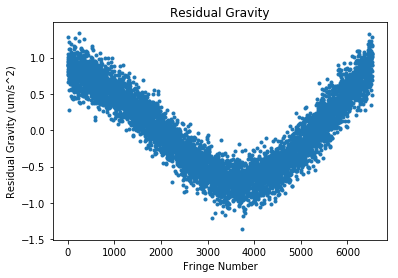

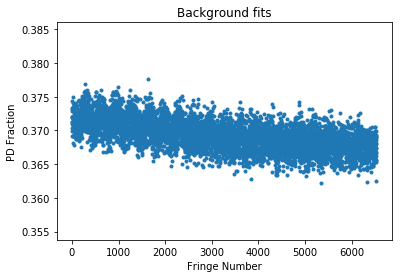

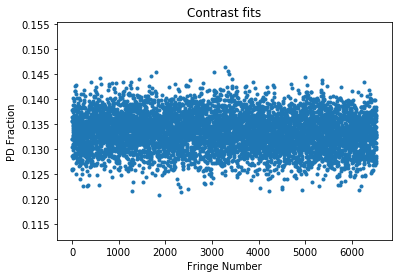

In [9]:
mcu_residue = plot_fits(g_mcu, c_mcu, b_mcu)

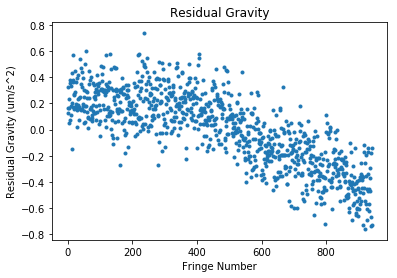

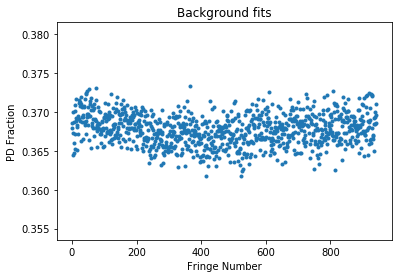

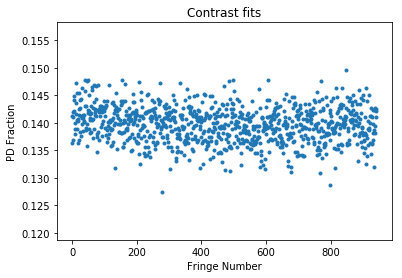

In [10]:
cicero_residue = plot_fits(g_cicero, c_cicero, b_cicero)

In [11]:
#averaging the residual gravity
def average_and_plot(data, bucket_size):
    avg_data = np.array([])
    std_data = np.array([])

    for i in np.arange(0, len(data), bucket_size):
        subset = data[i: i + bucket_size]
        avg_data = np.append(avg_data, np.average(subset))
        std_data = np.append(std_data, np.std(subset)/np.sqrt(bucket_size))

    group_idx = np.linspace(0, len(avg_data)*bucket_size, len(avg_data))
    plt.errorbar(group_idx, avg_data, fmt='k*:', yerr=std_data)
    plt.title("Group Avergaed Bucket Size: %d" % (bucket_size))
    plt.xlabel("Fringe Group Number")
    plt.ylabel("Residual Gravity (um/s^2)")    

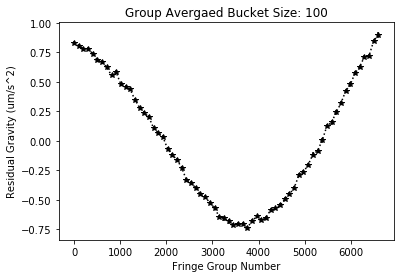

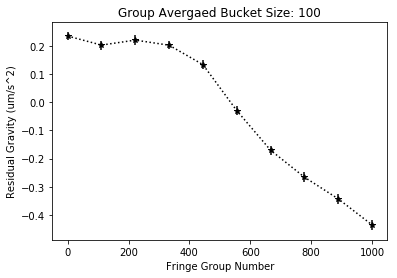

In [12]:
average_and_plot(mcu_residue, 100)
plt.show()
average_and_plot(cicero_residue, 100)
plt.show()

Sensitivity per fringe:  0.16681093984586326  um/s^2
Sensitivity per sqrt(hz):  0.44955857193232956  um/s^2


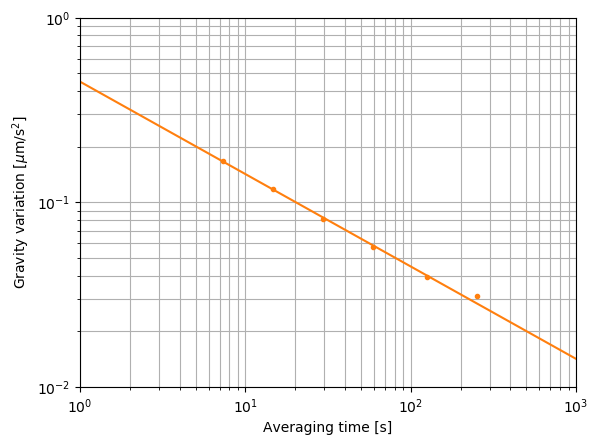

In [43]:
def plot_and_fit_allan_dev(data, sampling_rate, label=None, marker=None):
    t = [2**i for i in range(9)]
    (t2, ad, ade, adn) = allantools.oadev(data, rate=sampling_rate, data_type="freq", taus=t)
   
    if label:
        plt.errorbar(t2, ad, color=marker, fmt='.', yerr=ade, label=label)
        plt.grid(True, 'both', 'both')
    else:
        plt.errorbar(t2, ad, fmt='r*:', yerr=ade)
    plt.ylim(10e-3, 10e-1)
    plt.xlim(10e-1, 10e2)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Averaging time [s]")
    plt.ylabel("Gravity variation [$\mu$m/s$^2$]")

    def fitFunc(x, sense):
        return sense*(x**-0.5)

    fitParams, _ = curve_fit(fitFunc, t2[:5], ad[:5], maxfev=2**30)
    # Currently not using the covariances for anything

    allen_fit = lambda x: fitFunc(x, *fitParams)
    x_fit = np.logspace(0, 3)
    y_fit = allen_fit(x_fit)

    if not label:
        plt.plot(x_fit, y_fit)
    else:
        plt.plot(x_fit, y_fit, c=marker)
    print("Sensitivity per fringe: ", ad[0], " um/s^2")
    print("Sensitivity per sqrt(hz): ", allen_fit(1), " um/s^2")



mpl.rcdefaults()
sampling_rate_mcu = 1/(num_pts_per_fringe_mcu*.46)
plot_and_fit_allan_dev(mcu_residue, sampling_rate_mcu, 'MCU', 'tab:orange')
plt.show()


Sensitivity per fringe:  0.16681093984586326  um/s^2
Sensitivity per sqrt(hz):  0.44955857193232956  um/s^2
Sensitivity per fringe:  0.15205955834122725  um/s^2
Sensitivity per sqrt(hz):  0.7272481017079734  um/s^2


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


1.607142857142857
0.6027777777777777
6529


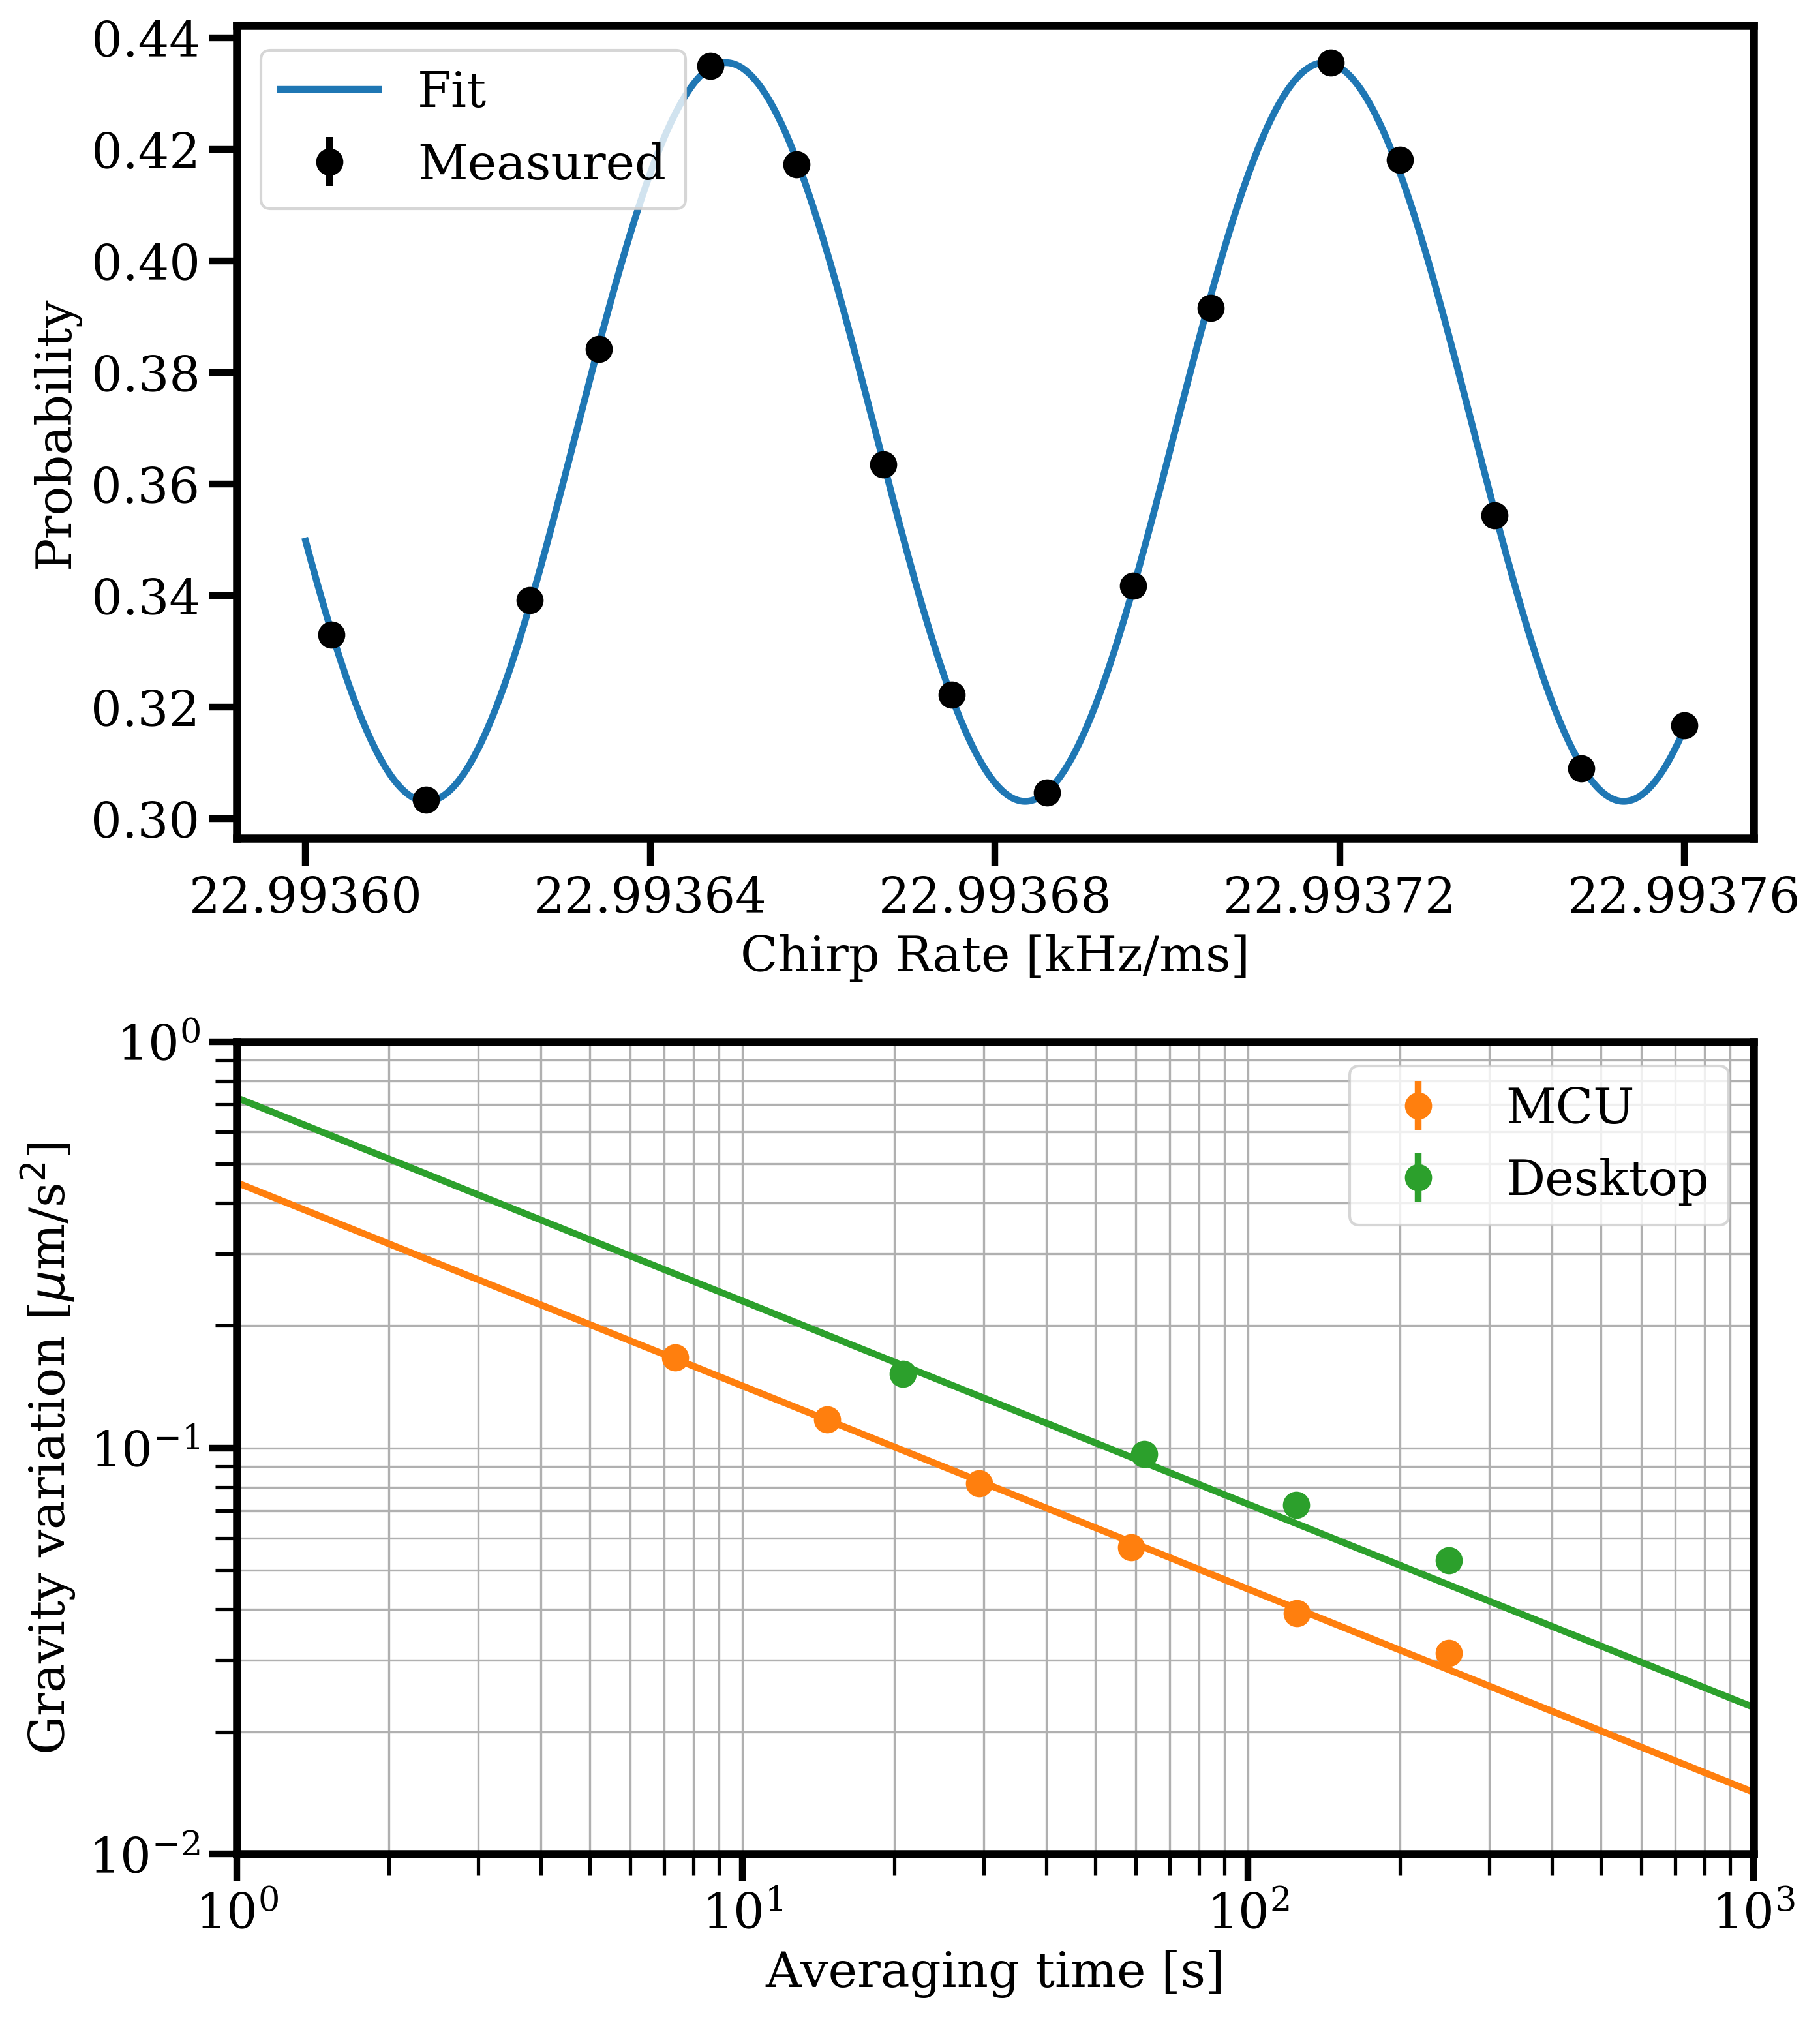

In [46]:
import pylab

sampling_rate_mcu = 1/(num_pts_per_fringe_mcu*.46)
sampling_rate_cicero = 1/(num_pts_per_fringe_cicero*1.3)

params = {'backend': 'svg',
          'font.family': 'serif',
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'xtick.major.width'    : 2.5,    # major tick width in points
          'xtick.minor.width'    : 1.25,    # minor tick width in points
          'ytick.major.width'    : 2.5,    # major tick width in points
          'ytick.minor.width'    : 1.25,    # minor tick width in points
          'xtick.major.size' : 10,      # major tick size in points
          'xtick.minor.size'     : 8,      # minor tick size in points
          'ytick.major.size' : 10,      # major tick size in points
          'ytick.minor.size'     : 8,      # minor tick size in points
          'axes.linewidth': 3,
          'axes.labelsize': 18,
          'lines.markersize' : 18,
          'text.usetex': False,
          'lines.linewidth': 2.5,
          'figure.dpi': 300,
          'figure.figsize': [2.5*4, 2.5*3*1.61803]}
pylab.rcParams.update(params)
pylab.show()

plt.subplot(212)
plot_and_fit_allan_dev(mcu_residue, sampling_rate_mcu, 'MCU', 'tab:orange')
plot_and_fit_allan_dev(cicero_residue, sampling_rate_cicero, 'Desktop', 'tab:green')
plt.legend()

ax = plt.subplot(211)
fitx = []
fity = []
std = []
for xe, ye in zip(xs_mcu, ys_mcu):
    fitx.append(xe)
    fity.append(np.average(ye))
    std.append(np.std(ye)/np.sqrt(len(ye)))

x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
nominal_w = 2 * np.pi * 120**2    
nominal_contrast = nom_vals_mcu[0]
nominal_background = nom_vals_mcu[1]
nominal_x0 = nom_vals_mcu[2]

w_tolerance = 0.0001
bg_tolerance = 0.05
amp_tolerance = 0.25
x0_tolerance = 0.1

def fitFunc(x, w, x0, b, c):
    return c/2*np.cos(w*(x - x0)) + b

fitBounds = ([(1 - w_tolerance)*nominal_w, (1-x0_tolerance)*nominal_x0, (1 - bg_tolerance)*nominal_background, (1 - amp_tolerance)*nominal_contrast],
             [(1 + w_tolerance)*nominal_w, (1+x0_tolerance)*nominal_x0,(1 + bg_tolerance)*nominal_background, (1 + amp_tolerance)*nominal_contrast])
fitParams, _ = curve_fit(fitFunc, fitx, fity, bounds=fitBounds, maxfev=2**64, xtol=1e-20)
fringe_func = lambda x: fitFunc(x, *fitParams)
x_fit = np.linspace(22.9936, 22.99376, 1e6)
y_fit = fringe_func(x_fit)
plt.plot(x_fit, y_fit, label="Fit")
plt.errorbar(fitx, fity, fmt='k.', yerr = std, label="Measured")
plt.legend(loc=2)
    
plt.xticks([22.9936, 22.99364,22.99368,22.99372,22.99376,])
plt.xlabel("Chirp Rate [kHz/ms]")
plt.ylabel("Probability")
plt.subplots_adjust(hspace=0.25)

plt.savefig('./Data Plots/results.svg', bbox_inches='tight')
mpl.rcdefaults()

print(.72/.448)

print(.434/.72)
print(len(mcu_residue))

In [75]:
###### Now we're going to try and subtract the tide model
tides = np.array([])
with open('9_25_overnight_tides.TSF') as f:
    for l in f:
        if l.startswith('#'):
            continue
        tides = np.append(tides, float(l.split()[-1]) * 1e-3)
        if len(tides) == num_fringes:
            break
tides = (tides - np.average(tides))

fringe_id = np.linspace(0, len(tides), len(tides))
plt.scatter(fringe_id, tides)
plt.title("Tide Model Predictions")
plt.xlabel("Fringe")
plt.ylabel("Residual Gravity (um/s^2)")
average_and_plot(g_residue, 200)
plt.show()

NameError: name 'num_fringes' is not defined

In [39]:
# def fitFunc(x, a1, a2, a3, a4, b1, b2, b3,b4,c1,c2,c3,c4,bg):
#     return a1*np.sin(b1*x + c1) +a2*np.sin(b2*x + c2) +a3*np.sin(b3*x + c3) +a4*np.sin(b4*x + c4) + bg 


# a_low = 0
# a_high = 2
# b_low = 0
# b_high = 0.5
# c_low = 0
# c_high = 2*np.pi
# p0 = np.ones(19)
# fitBounds = ([a_low,a_low,a_low,a_low, b_low, b_low, b_low, b_low,c_low,c_low,c_low,c_low,-0.75],
#              [a_high, a_high, a_high,a_high,b_high, b_high,b_high,b_high,c_high,c_high,c_high,c_high,0.75])
# fitParams, _ = curve_fit(fitFunc, np.linspace(0, len(g_residue), len(g_residue)), g_residue, bounds=fitBounds, maxfev=2**24)
# # Currently not using the covariances for anything
# print(fitParams)
# fitted_tides = lambda x: fitFunc(x, *fitParams)

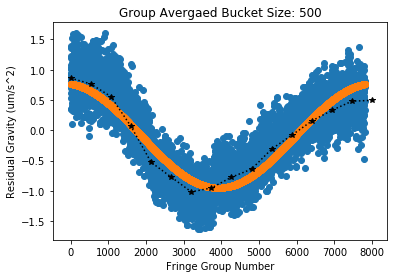

In [40]:
shift = 500
init_drop = 0
end_drop = -1000
g_res_shift = g_residue[init_drop + shift:end_drop]
tides_shift = tides[init_drop:end_drop - shift]
x_common = np.linspace(0, len(g_res_shift), len(g_res_shift))
plt.scatter(x_common, g_res_shift)
plt.scatter(x_common, tides_shift)
average_and_plot(g_res_shift, 500)
# plt.scatter(x_common, fitted_tides(x_common))

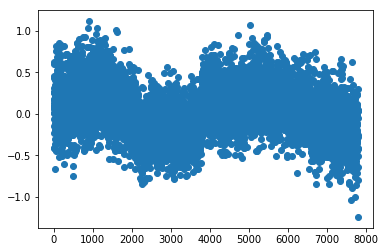

In [41]:
g_variation = g_res_shift - tides_shift
plt.scatter(np.linspace(0, len(g_variation), len(g_variation)), g_variation)

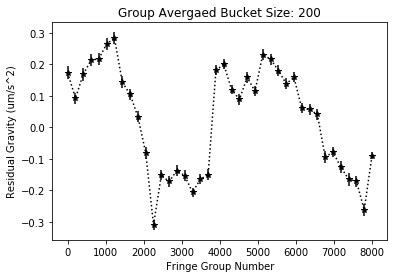

In [42]:
average_and_plot(g_variation, 200)

In [44]:
plot_and_fit_allan_dev(g_variation, sampling_rate)
plot_and_fit_allan_dev(g_variation, 1/(num_pts_per_fringe*(cycle_time_s+0.5)))
plt.show()


NameError: name 'g_variation' is not defined

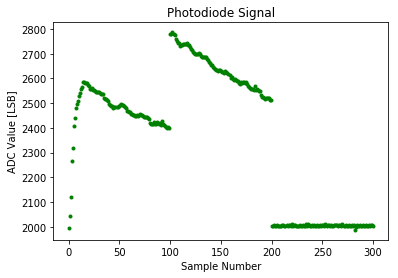